# Plot Malignancy Estimation Results

Code adapted from the following repositories:

* [Kiran model](https://github.com/DIAGNijmegen/bodyct-nodule-malignancy)
* [Thijmen model](https://github.com/DIAGNijmegen/bodyct-lung-malignancy)
* [StackOverflow on right-align legend text](https://stackoverflow.com/questions/7936034/text-alignment-in-a-matplotlib-legend)

In [1]:
import pandas as pd
import os
import numpy as np

import seaborn as sns
sns.set_style("white")
from evalutils.roc import get_bootstrapped_roc_ci_curves
import matplotlib.pyplot as plt

%matplotlib inline
import sklearn.metrics as skl_metrics

import utils
from utils import plot_rocs

## Read Data (DLCST results)

In [2]:
## directory where results are
LOCAL_PC = False
root_dir = "/mnt/w" if LOCAL_PC else ""
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
DLCST_PREDS = f"{EXPERIMENT_DIR}/dlcst"

DLCST_PREDS_LOCAL = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/dlcst"
DLCST_PREDS = DLCST_PREDS_LOCAL ## Comment out if not using Teams backup (aka Chansey is up :)

In [3]:
## Read DLCST results
df_results = pd.read_csv(f"{DLCST_PREDS}/dlcst_thijmen_kiran_sybil_malignancy_estimation_results.csv", header=0)
df_results.head()

,PatientID,StudyDate,SeriesInstanceUID,Age,Sex,FamilyHistoryLungCa,Emphysema,NoduleCountPerScan,sybil_year1,sybil_year2,sybil_year3,sybil_year4,sybil_year5,sybil_year6,PanCan2b,Ensemble_Kiran,thijmen_mean,label
0,4,20050124,1.2.840.113704.1.111.4964.1106577805.10,55,2,0,0,9,0.021629,0.038573,0.071919,0.079270,0.095846,0.135681,0.053366,0.082652,0.166209,0
1,35,20051208,1.2.840.113704.1.111.5776.1134059140.11,56,1,1,1,2,0.001170,0.002554,0.007835,0.011039,0.018442,0.030460,0.009543,0.000408,0.003368,0
2,38,20060109,1.2.840.113704.1.111.2004.1136823831.14,62,2,0,1,4,0.001784,0.003870,0.007835,0.012797,0.019229,0.032957,0.006734,0.002702,0.065888,0
3,47,20051214,1.2.840.113704.1.111.8148.1134579622.14,57,1,0,1,1,0.003951,0.015674,0.025373,0.034010,0.040605,0.058852,0.007944,0.084158,0.423341,0
4,56,20051213,1.2.840.113704.1.111.2744.1134487263.11,64,1,0,1,3,0.000000,0.001574,0.003791,0.006847,0.010381,0.017287,0.000899,0.000013,0.005590,0


In [4]:
len(pd.unique(df_results['SeriesInstanceUID'])), len(pd.unique(df_results['PatientID']))

(599, 599)

In [5]:
df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            599 non-null    int64  
 1   StudyDate            599 non-null    int64  
 2   SeriesInstanceUID    599 non-null    object 
 3   Age                  599 non-null    int64  
 4   Sex                  599 non-null    int64  
 5   FamilyHistoryLungCa  599 non-null    int64  
 6   Emphysema            599 non-null    int64  
 7   NoduleCountPerScan   599 non-null    int64  
 8   sybil_year1          599 non-null    float64
 9   sybil_year2          599 non-null    float64
 10  sybil_year3          599 non-null    float64
 11  sybil_year4          599 non-null    float64
 12  sybil_year5          599 non-null    float64
 13  sybil_year6          599 non-null    float64
 14  PanCan2b             599 non-null    float64
 15  Ensemble_Kiran       599 non-null    flo

In [6]:
df_results.describe()

,PatientID,StudyDate,Age,Sex,FamilyHistoryLungCa,Emphysema,NoduleCountPerScan,sybil_year1,sybil_year2,sybil_year3,sybil_year4,sybil_year5,sybil_year6,PanCan2b,Ensemble_Kiran,thijmen_mean,label
count,599.000000,5.990000e+02,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,5.990000e+02,599.000000,599.000000
mean,1883.756260,2.005100e+07,58.397329,1.460768,0.170284,0.676127,1.769616,0.025965,0.040542,0.050433,0.058651,0.067412,0.089968,0.055902,1.461987e-01,0.166094,0.098497
std,1215.815006,7.593265e+03,4.946103,0.498875,0.376196,0.468343,1.165421,0.080576,0.104781,0.111505,0.115754,0.121409,0.135617,0.118722,2.966031e-01,0.241460,0.298235
min,4.000000,2.004111e+07,50.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.820000e-07,0.000574,0.000000
25%,800.500000,2.005013e+07,54.000000,1.000000,0.000000,0.000000,1.000000,0.001170,0.002554,0.007835,0.012797,0.019229,0.032957,0.002396,2.369950e-04,0.011600,0.000000
50%,1689.000000,2.005052e+07,58.000000,1.000000,0.000000,1.000000,1.000000,0.001965,0.005733,0.010996,0.015721,0.021112,0.035951,0.007804,2.825316e-03,0.045436,0.000000
75%,3011.500000,2.005103e+07,62.000000,2.000000,0.000000,1.000000,2.000000,0.007145,0.020146,0.029786,0.039906,0.051451,0.076318,0.044897,6.282042e-02,0.201205,0.000000
max,4099.000000,2.009122e+07,75.000000,2.000000,1.000000,1.000000,9.000000,0.838213,0.903660,0.902390,0.914693,0.914693,0.914693,0.789437,9.988375e-01,0.977596,1.000000


<Axes: xlabel='Age', ylabel='Count'>

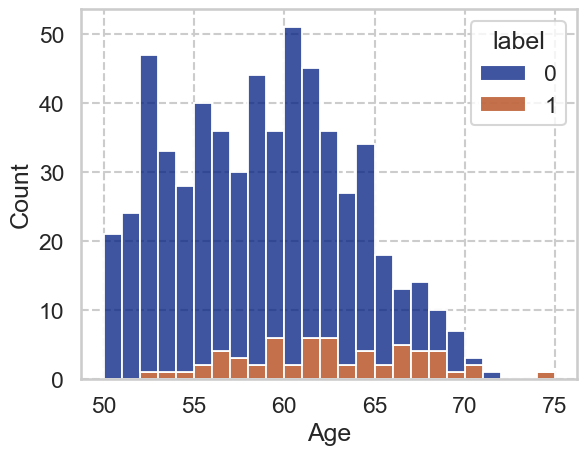

In [7]:
sns.histplot(df_results, x="Age", bins=25, hue="label", multiple='stack')

In [8]:
df_results.query('Age == 70')['label'].value_counts()

label
1    2
0    1
Name: count, dtype: int64

In [9]:
df_malignant = df_results.query('label == 1')
df_malignant.describe()

,PatientID,StudyDate,Age,Sex,FamilyHistoryLungCa,Emphysema,NoduleCountPerScan,sybil_year1,sybil_year2,sybil_year3,sybil_year4,sybil_year5,sybil_year6,PanCan2b,Ensemble_Kiran,thijmen_mean,label
count,59.000000,5.900000e+01,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.0
mean,2226.067797,2.006203e+07,62.000000,1.457627,0.271186,0.745763,1.711864,0.145046,0.200687,0.222831,0.240233,0.258463,0.307859,0.221539,0.698916,0.616382,1.0
std,1146.619783,1.472711e+04,4.856563,0.502478,0.448388,0.439169,1.175187,0.179729,0.218469,0.226036,0.228718,0.236872,0.248971,0.201549,0.336146,0.273137,0.0
min,62.000000,2.004112e+07,52.000000,1.000000,0.000000,0.000000,1.000000,0.000421,0.002048,0.006331,0.010185,0.014170,0.022664,0.003140,0.000115,0.007771,1.0
25%,1303.500000,2.005072e+07,59.000000,1.000000,0.000000,0.500000,1.000000,0.010938,0.023848,0.040202,0.056078,0.068311,0.104660,0.050493,0.528134,0.474855,1.0
50%,2218.000000,2.005121e+07,62.000000,1.000000,0.000000,1.000000,1.000000,0.084456,0.143517,0.172521,0.197799,0.211975,0.276596,0.167578,0.833620,0.678868,1.0
75%,3300.500000,2.007056e+07,66.000000,2.000000,1.000000,1.000000,2.000000,0.215565,0.306710,0.306925,0.337119,0.365862,0.415215,0.296643,0.971705,0.837449,1.0
max,4032.000000,2.009122e+07,75.000000,2.000000,1.000000,1.000000,7.000000,0.838213,0.903660,0.902390,0.914693,0.914693,0.914693,0.789437,0.998838,0.977596,1.0


### Define DLCST Splits
DataFrame queries for subsets. Can use this for plots and whatnot.

In [10]:
SPLIT_QUERIES = {
    "sex": {
        "male": 'Sex == 1',
        "female": 'Sex == 2' 
    },
    "family history": {
        "no": 'FamilyHistoryLungCa == 0',
        "yes": 'FamilyHistoryLungCa == 1' 
    },
    "emphysema": {
        "no": 'Emphysema == 0',
        "yes": 'Emphysema == 1' 
    },
    "age": {
        "50-62": '50 <= Age < 62',
        "62+": '62 <= Age', 
    },
    "nodule count": {
        "1": 'NoduleCountPerScan == 1',
        ">1": 'NoduleCountPerScan > 1' 
    }
}

In [11]:
def get_split_dfs(df, split_by="sex", printinfo=True):
    subset_dfs = {}
    for (split, query) in SPLIT_QUERIES[split_by].items():
        subset_dfs[split] = df.query(query)
        
        if printinfo:
            mal_count = len(subset_dfs[split].query('label == 1'))
            mal_percent = 100 * (mal_count / len(subset_dfs[split]))
            print(f"{split}, n={len(subset_dfs[split])}, {mal_count} malignant ({mal_percent:.2f}%)")
    
    return subset_dfs

## ROC Plots

### Compare ROCs across models

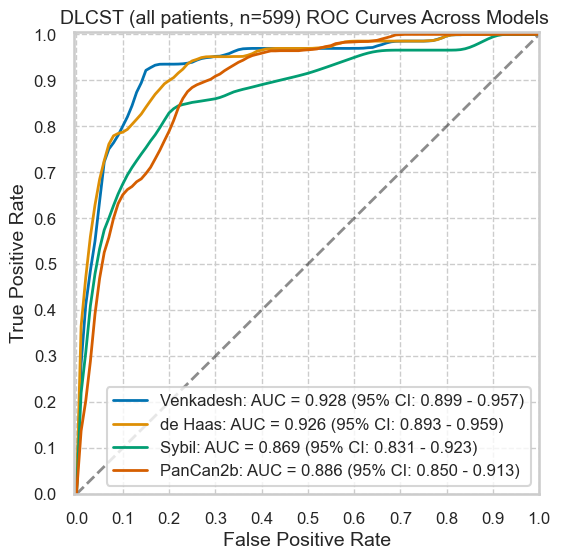

In [12]:
MODEL_TO_COL = {
    "Venkadesh": "Ensemble_Kiran",
    "de Haas": "thijmen_mean",
    "Sybil": "sybil_year1",
    "PanCan2b": "PanCan2b",
}

def rocs_models(df, true_col='label', models=["Venkadesh", "de Haas", "Sybil", "PanCan2b"], dataset_label="DLCST", subset_label="all", imgpath=None, plot_ci=False):
    rocs = {}
    for m in models:
        rocs[m] = get_bootstrapped_roc_ci_curves(df[MODEL_TO_COL[m]].values, df[true_col].values)
    
    plot_rocs(rocs, f'{dataset_label} ({subset_label} patients, n={len(df)}) ROC Curves Across Models ', imgpath, plot_ci)

rocs_models(df_results)

### Compare Model Performance For Each Split

male, n=323, 32 malignant (9.91%)
female, n=276, 27 malignant (9.78%)


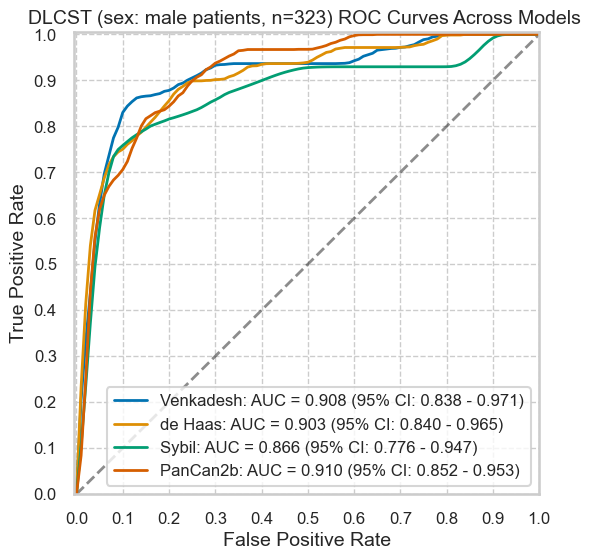

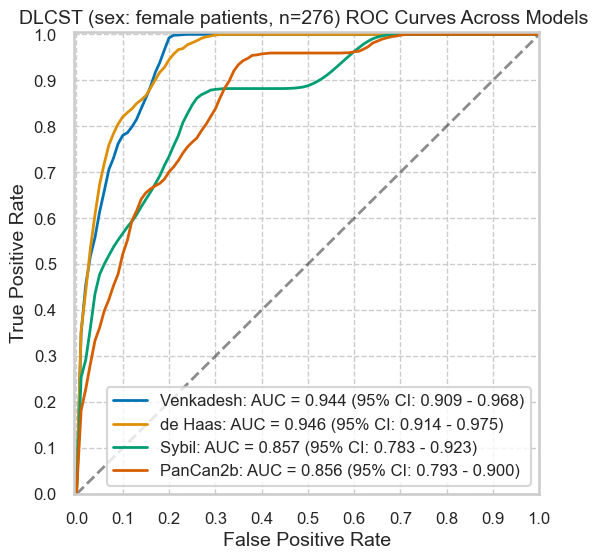

no, n=497, 43 malignant (8.65%)
yes, n=102, 16 malignant (15.69%)


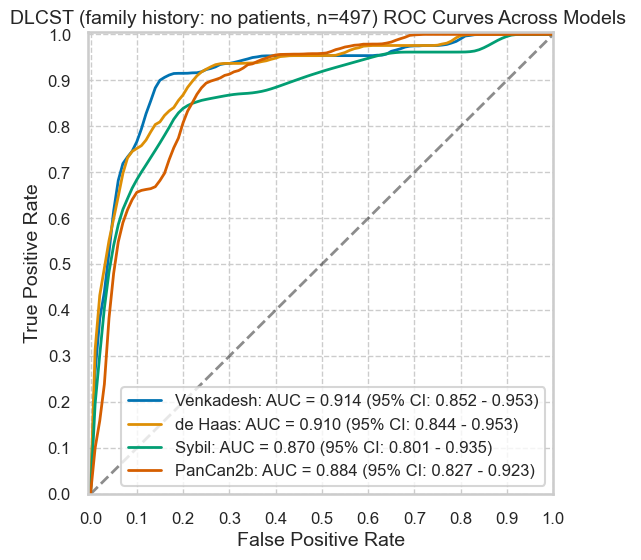

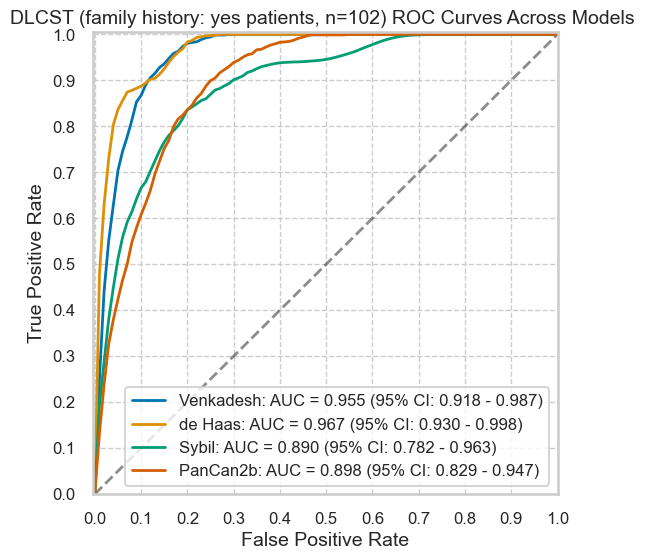

no, n=194, 15 malignant (7.73%)
yes, n=405, 44 malignant (10.86%)


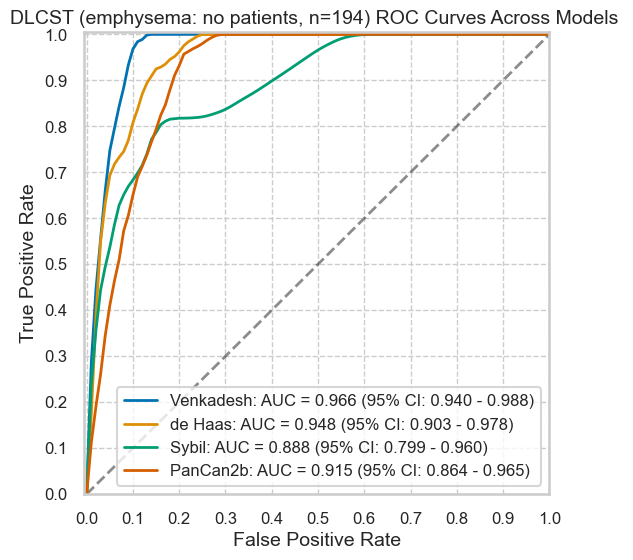

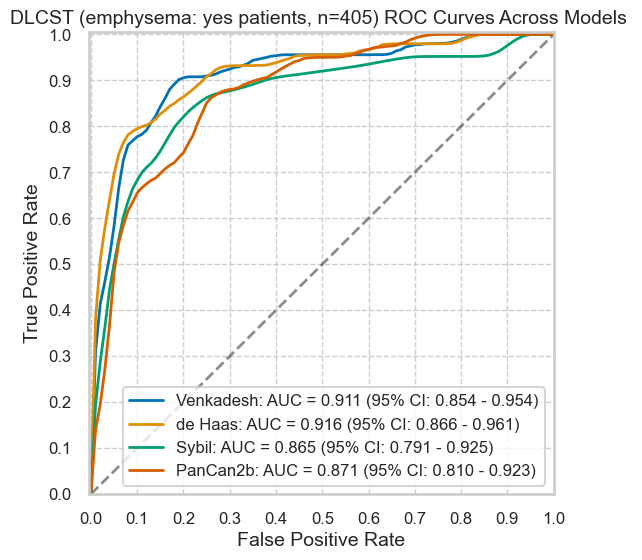

50-62, n=435, 28 malignant (6.44%)
62+, n=164, 31 malignant (18.90%)


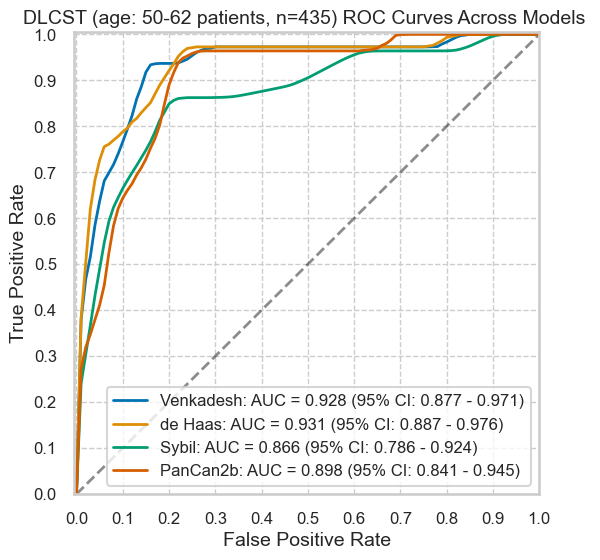

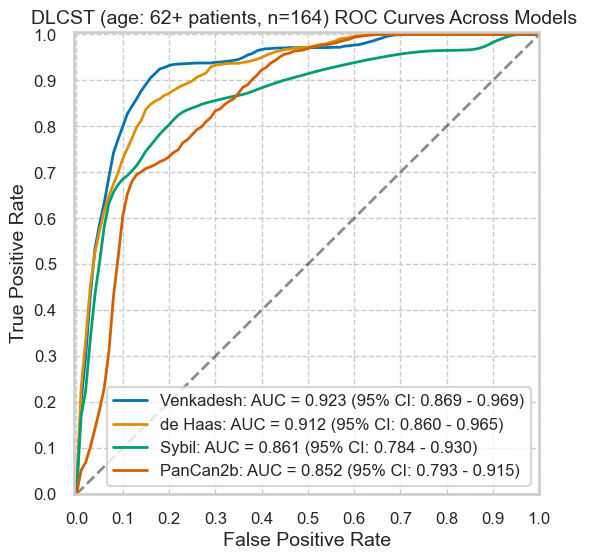

1, n=333, 35 malignant (10.51%)
>1, n=266, 24 malignant (9.02%)


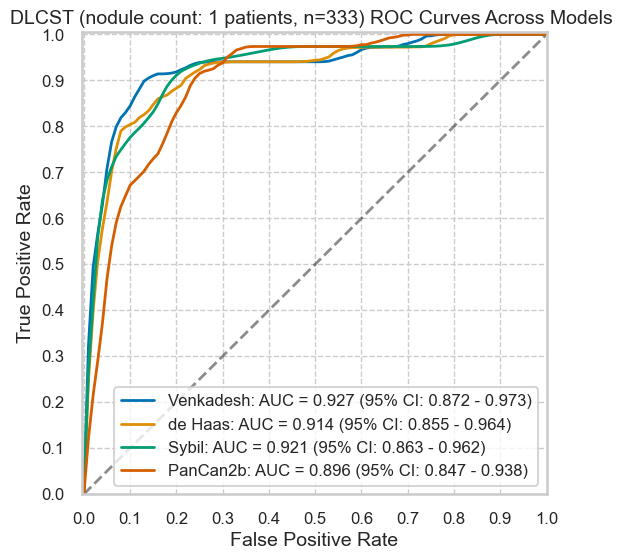

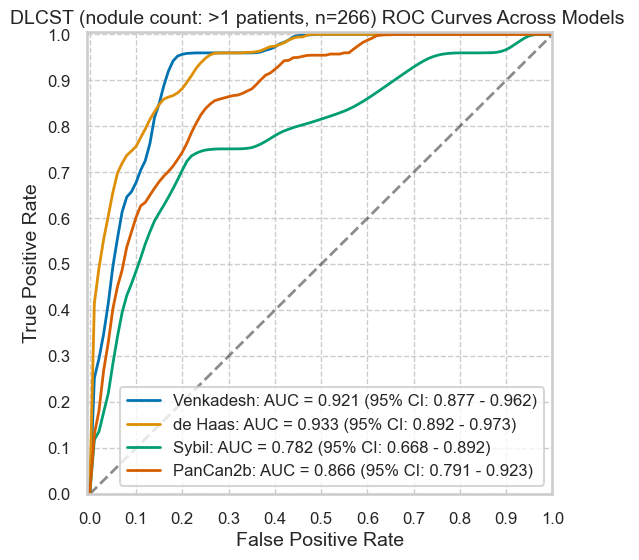

In [13]:
for split_type in SPLIT_QUERIES:
    subset_dfs = get_split_dfs(df_results, split_by=split_type)
    for split, df_sub in subset_dfs.items():
        rocs_models(df_sub, subset_label=f'{split_type}: {split}')

### Plot Splits for Same Model

In [14]:
def rocs_splits(df, cat="sex", dataset_label="DLCST", true_col='label', models=MODEL_TO_COL, imgpath=None, plot_ci=False):
    groups = get_split_dfs(df, cat, printinfo=False).items()

    df_catinfo, skips = utils.info_by_splits(groups, 2)
    display(df_catinfo)
    # plot_roc = (0 not in df_catinfo['num_mal']) and (len() not in df_catinfo['pct_mal'])

    rocs = {}
    for m in models:
        rocs[m], df_perf = utils.perf_by_splits(groups, pred_col=MODEL_TO_COL[m])
        print(m)
        display(df_perf)

    do_sigtest = (len(df_catinfo) - len(skips)) == 2
    bin_sigtest_results = {}

    fig, ax = plt.subplots(1, len(models), figsize=(6.5 * len(models) - 0.5, 6.5))
    fig.suptitle(f"Model Performance Split By {cat}")
    for i, m in enumerate(models):
        title_str = m
        if do_sigtest:
            z, p = utils.hanley_mcneil_sigtest(df_catinfo, skips, rocs[m])
            title_str = f"{m}\n(z={z:.6f}, p={p:.6f})"
            bin_sigtest_results[m] = {"z": z, "p": p}

        utils.ax_rocs(ax[i], rocs[m], title=title_str)
    plt.show()

    df_sigtest_results = None
    if do_sigtest:
        df_sigtest_results = pd.DataFrame(bin_sigtest_results)
    
    display(df_sigtest_results)

    return df_sigtest_results

    # rocs = {}
    # rocs['all'] = get_bootstrapped_roc_ci_curves(df[MODEL_TO_COL[model]].values, df[true_col].values)   
    # for split, df_subset in subset_dfs.items():
    #     rocs[split] = get_bootstrapped_roc_ci_curves(df_subset[MODEL_TO_COL[model]].values, df_subset[true_col].values)
    
    # plot_rocs(rocs, f'{dataset_label} (split by {split_by}) ROC Curves for {model} Model', imgpath, plot_ci)

,num,pct,num_mal,pct_mal
male,323,53.923205,32,9.907121
female,276,46.076795,27,9.782609


Venkadesh


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
male,323,29,62,229,3,0.90625,0.213058,0.09375,0.786942,0.318681,0.987069,0.681319,0.012931,0.798762,0.693192,0.471545,0.460373
female,276,27,83,166,0,1.00000,0.333333,0.00000,0.666667,0.245455,1.000000,0.754545,0.000000,0.699275,0.666667,0.394161,0.404520


de Haas


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
male,323,31,190,101,1,0.96875,0.652921,0.03125,0.347079,0.140271,0.990196,0.859729,0.009804,0.408669,0.315829,0.245059,0.202991
female,276,27,174,75,0,1.00000,0.698795,0.00000,0.301205,0.134328,1.000000,0.865672,0.000000,0.369565,0.301205,0.236842,0.201148


Sybil


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
male,323,24,24,267,8,0.75000,0.082474,0.25000,0.917526,0.500000,0.970909,0.500000,0.029091,0.900929,0.667526,0.60000,0.560664
female,276,17,35,214,10,0.62963,0.140562,0.37037,0.859438,0.326923,0.955357,0.673077,0.044643,0.836957,0.489067,0.43038,0.371556


PanCan2b


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
male,323,29,78,213,3,0.906250,0.268041,0.093750,0.731959,0.271028,0.986111,0.728972,0.013889,0.749226,0.638209,0.417266,0.405103
female,276,26,109,140,1,0.962963,0.437751,0.037037,0.562249,0.192593,0.992908,0.807407,0.007092,0.601449,0.525212,0.320988,0.312133


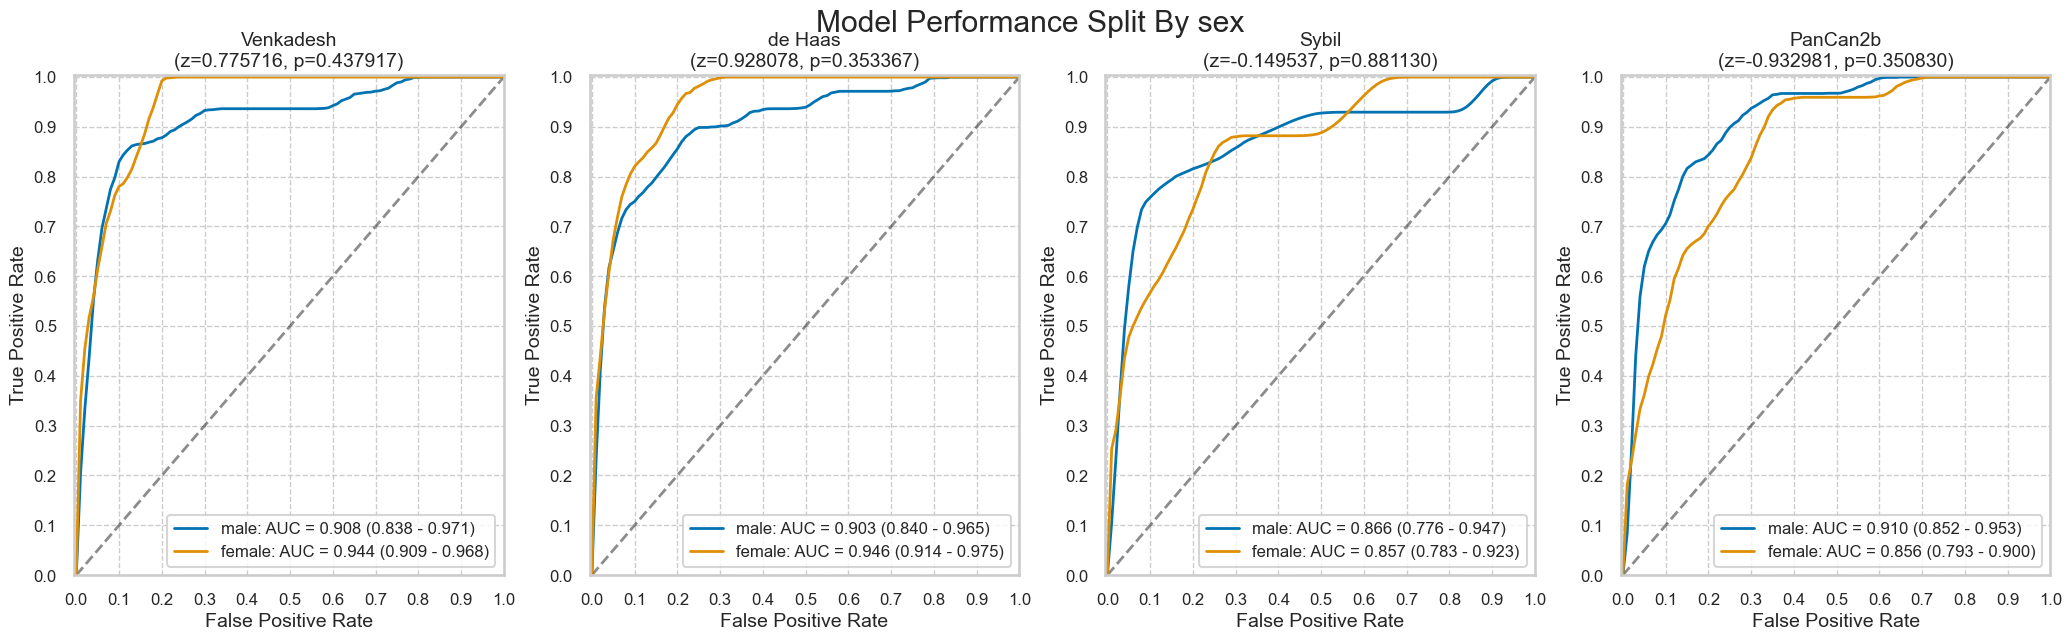

,Venkadesh,de Haas,Sybil,PanCan2b
z,0.775716,0.928078,-0.149537,-0.932981
p,0.437917,0.353367,0.881130,0.350830


,num,pct,num_mal,pct_mal
no,497,82.971619,43,8.651911
yes,102,17.028381,16,15.686275


Venkadesh


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
no,497,40,119,335,3,0.930233,0.262115,0.069767,0.737885,0.251572,0.991124,0.748428,0.008876,0.754527,0.668118,0.396040,0.402678
yes,102,16,26,60,0,1.000000,0.302326,0.000000,0.697674,0.380952,1.000000,0.619048,0.000000,0.745098,0.697674,0.551724,0.515539


de Haas


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
no,497,42,308,146,1,0.976744,0.678414,0.023256,0.321586,0.120000,0.993197,0.880000,0.006803,0.37827,0.298330,0.213740,0.183767
yes,102,16,56,30,0,1.000000,0.651163,0.000000,0.348837,0.222222,1.000000,0.777778,0.000000,0.45098,0.348837,0.363636,0.278423


Sybil


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
no,497,29,48,406,14,0.674419,0.105727,0.325581,0.894273,0.376623,0.966667,0.623377,0.033333,0.875252,0.568692,0.483333,0.441844
yes,102,12,11,75,4,0.750000,0.127907,0.250000,0.872093,0.521739,0.949367,0.478261,0.050633,0.852941,0.622093,0.615385,0.541361


PanCan2b


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
no,497,39,154,300,4,0.906977,0.339207,0.093023,0.660793,0.202073,0.986842,0.797927,0.013158,0.682093,0.567770,0.330508,0.327506
yes,102,16,33,53,0,1.000000,0.383721,0.000000,0.616279,0.326531,1.000000,0.673469,0.000000,0.676471,0.616279,0.492308,0.448591


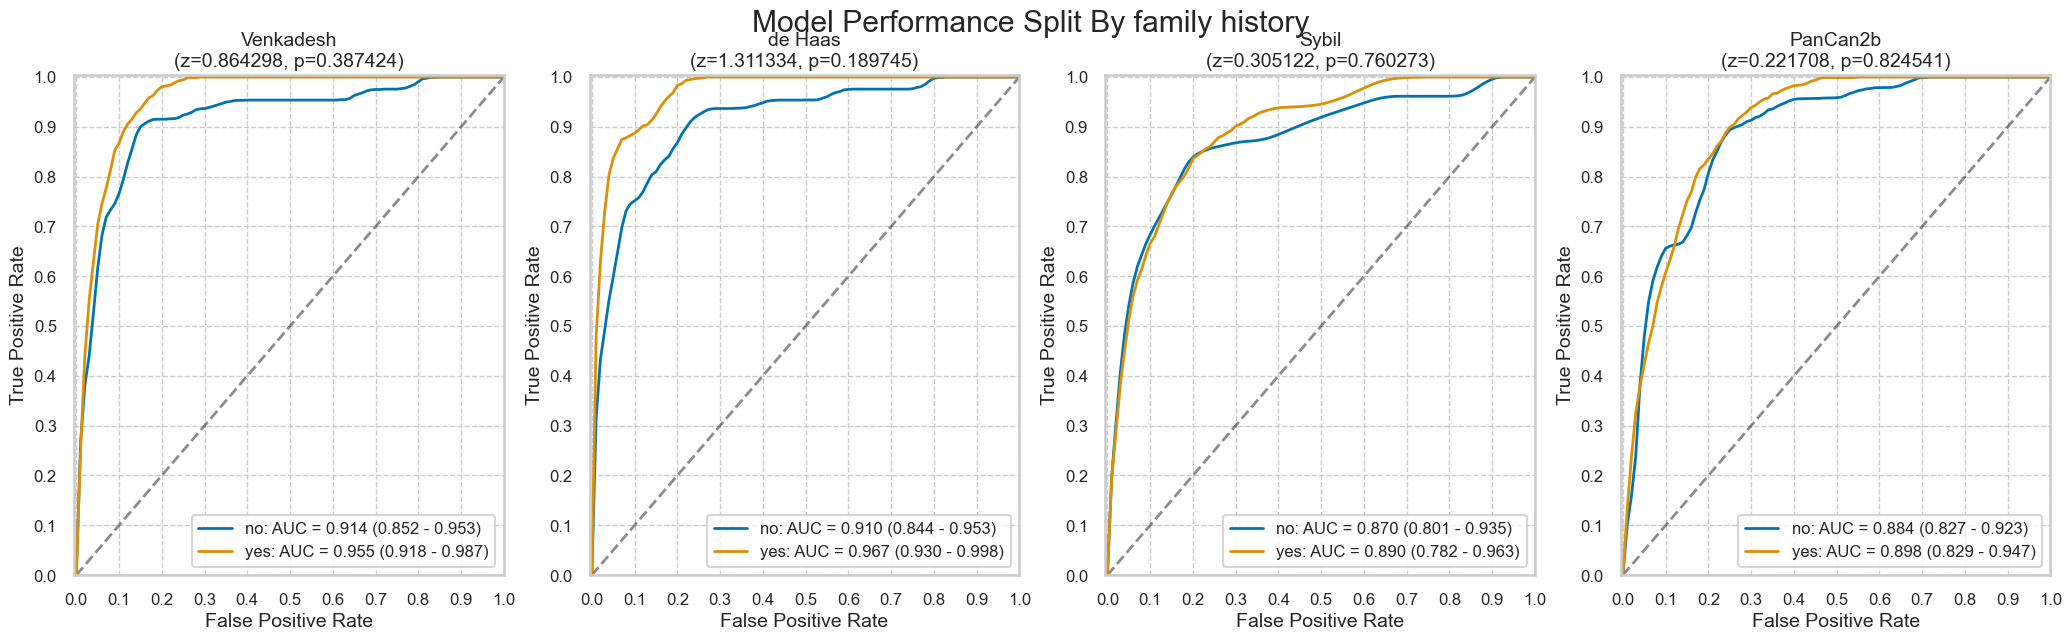

,Venkadesh,de Haas,Sybil,PanCan2b
z,0.864298,1.311334,0.305122,0.221708
p,0.387424,0.189745,0.760273,0.824541


,num,pct,num_mal,pct_mal
no,194,32.387312,15,7.731959
yes,405,67.612688,44,10.864198


Venkadesh


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
no,194,15,37,142,0,1.000000,0.206704,0.000000,0.793296,0.288462,1.000000,0.711538,0.000000,0.809278,0.793296,0.447761,0.478367
yes,405,41,108,253,3,0.931818,0.299169,0.068182,0.700831,0.275168,0.988281,0.724832,0.011719,0.725926,0.632649,0.424870,0.408253


de Haas


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
no,194,15,112,67,0,1.000000,0.625698,0.000000,0.374302,0.118110,1.000000,0.881890,0.000000,0.422680,0.374302,0.211268,0.210259
yes,405,43,252,109,1,0.977273,0.698061,0.022727,0.301939,0.145763,0.990909,0.854237,0.009091,0.375309,0.279212,0.253687,0.195347


Sybil


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
no,194,10,12,167,5,0.666667,0.067039,0.333333,0.932961,0.454545,0.970930,0.545455,0.029070,0.912371,0.599628,0.540541,0.505101
yes,405,31,47,314,13,0.704545,0.130194,0.295455,0.869806,0.397436,0.960245,0.602564,0.039755,0.851852,0.574352,0.508197,0.453249


PanCan2b


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
no,194,15,45,134,0,1.000000,0.251397,0.000000,0.748603,0.25000,1.000000,0.75000,0.000000,0.768041,0.748603,0.400000,0.432609
yes,405,40,142,219,4,0.909091,0.393352,0.090909,0.606648,0.21978,0.982063,0.78022,0.017937,0.639506,0.515739,0.353982,0.322643


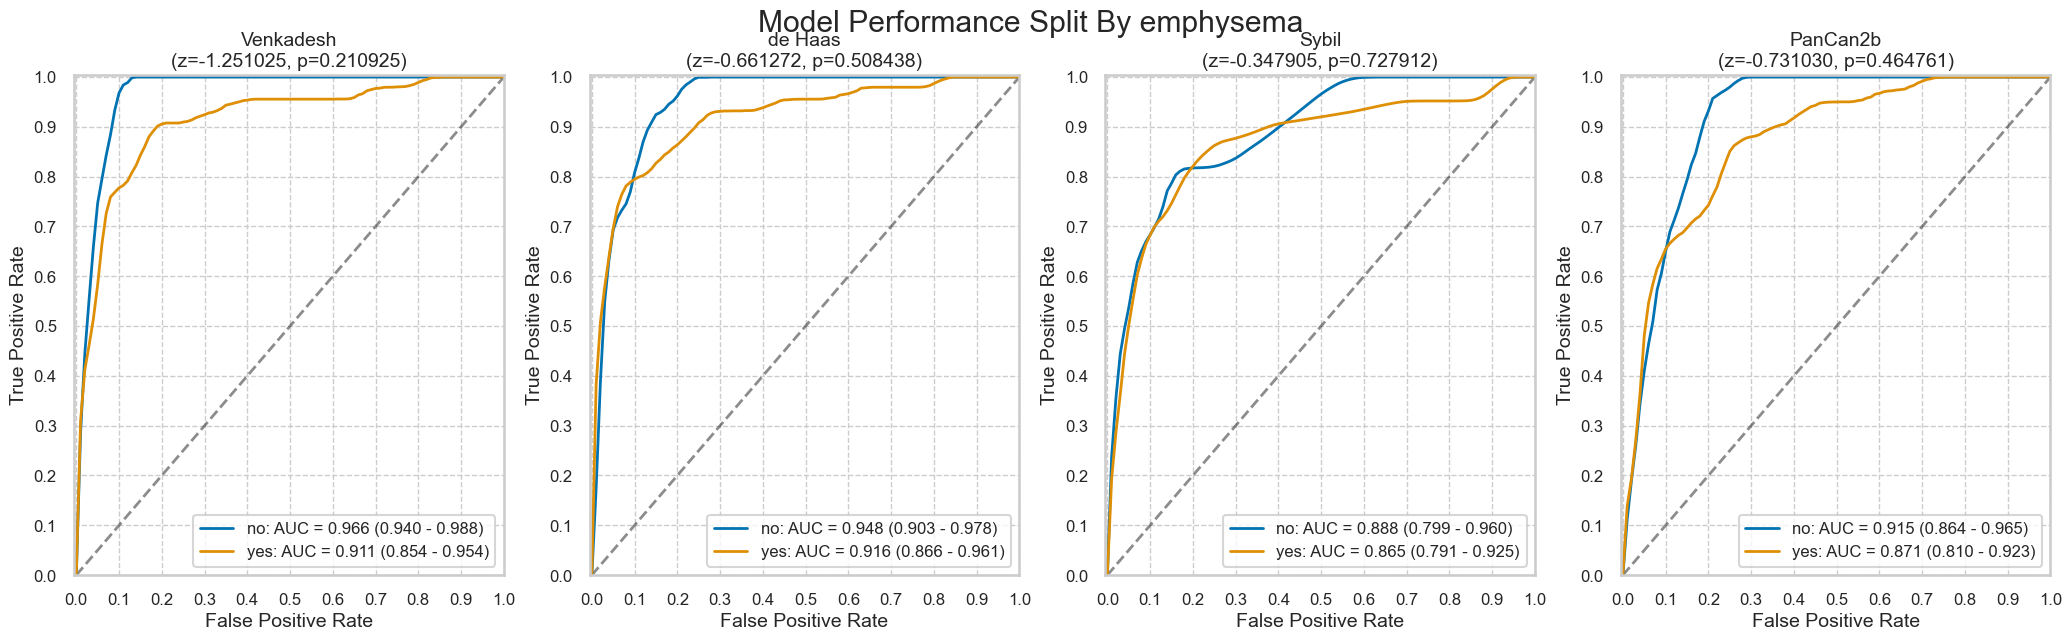

,Venkadesh,de Haas,Sybil,PanCan2b
z,-1.251025,-0.661272,-0.347905,-0.731030
p,0.210925,0.508438,0.727912,0.464761


,num,pct,num_mal,pct_mal
50-62,435,72.621035,28,6.436782
62+,164,27.378965,31,18.902439


Venkadesh


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
50-62,435,27,105,302,1,0.964286,0.257985,0.035714,0.742015,0.204545,0.996700,0.795455,0.003300,0.756322,0.706300,0.3375,0.377014
62+,164,29,40,93,2,0.935484,0.300752,0.064516,0.699248,0.420290,0.978947,0.579710,0.021053,0.743902,0.634732,0.5800,0.503397


de Haas


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
50-62,435,27,271,136,1,0.964286,0.665848,0.035714,0.334152,0.090604,0.992701,0.909396,0.007299,0.374713,0.298438,0.165644,0.157675
62+,164,31,93,40,0,1.000000,0.699248,0.000000,0.300752,0.250000,1.000000,0.750000,0.000000,0.432927,0.300752,0.400000,0.274204


Sybil


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
50-62,435,18,39,368,10,0.642857,0.095823,0.357143,0.904177,0.315789,0.973545,0.684211,0.026455,0.887356,0.547034,0.423529,0.397839
62+,164,23,20,113,8,0.741935,0.150376,0.258065,0.849624,0.534884,0.933884,0.465116,0.066116,0.829268,0.591560,0.621622,0.526597


PanCan2b


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
50-62,435,27,134,273,1,0.964286,0.329238,0.035714,0.670762,0.167702,0.996350,0.832298,0.003650,0.689655,0.635047,0.285714,0.322771
62+,164,28,53,80,3,0.903226,0.398496,0.096774,0.601504,0.345679,0.963855,0.654321,0.036145,0.658537,0.504730,0.500000,0.395261


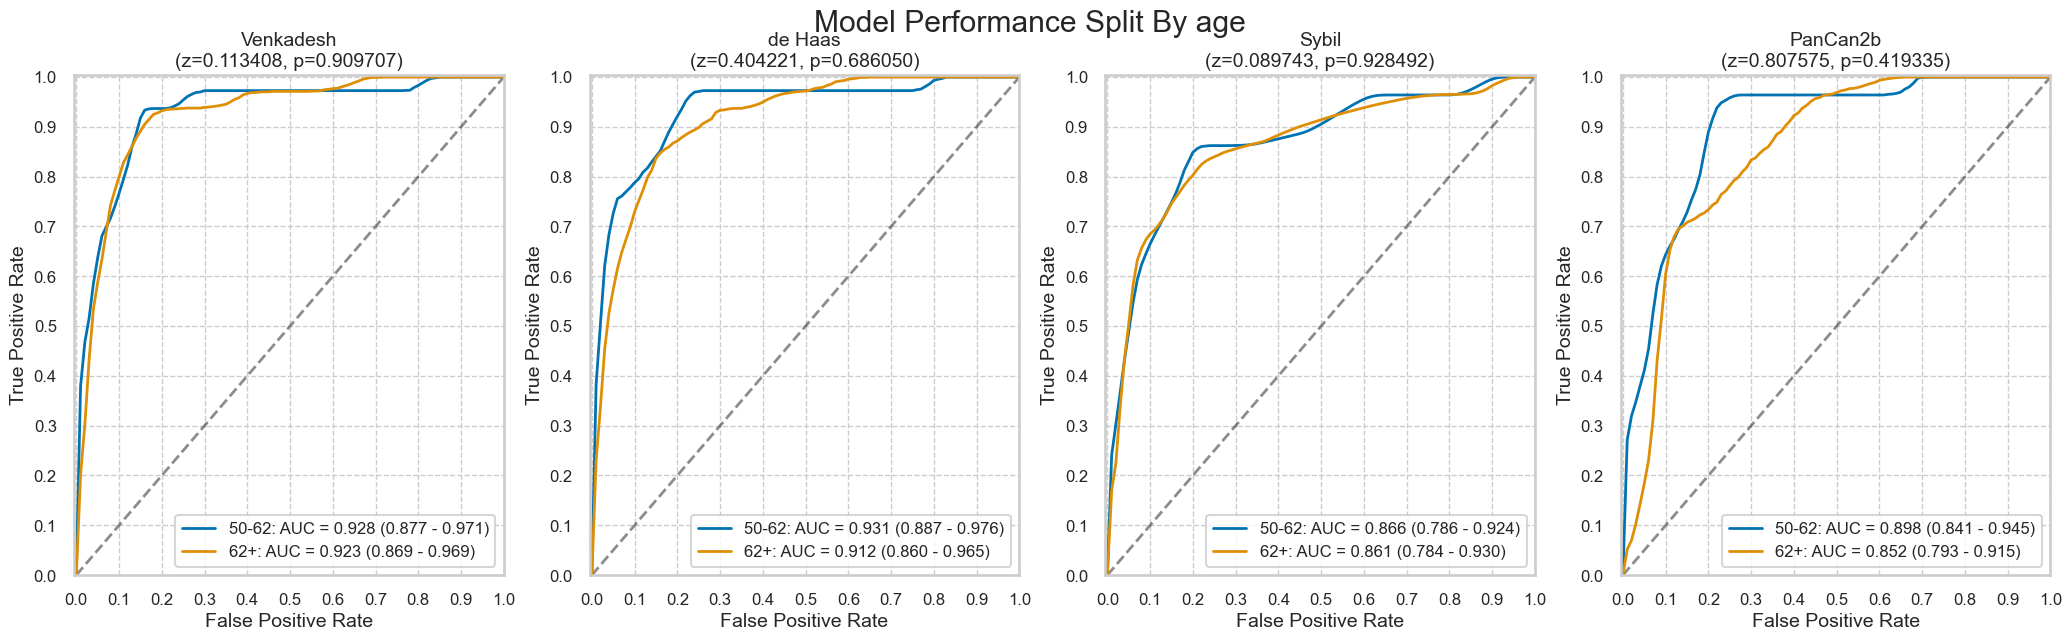

,Venkadesh,de Haas,Sybil,PanCan2b
z,0.113408,0.404221,0.089743,0.807575
p,0.909707,0.686050,0.928492,0.419335


,num,pct,num_mal,pct_mal
1,333,55.592654,35,10.510511
>1,266,44.407346,24,9.022556


Venkadesh


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
1,333,33,67,231,2,0.942857,0.224832,0.057143,0.775168,0.330000,0.991416,0.670000,0.008584,0.792793,0.718025,0.488889,0.480401
>1,266,23,78,164,1,0.958333,0.322314,0.041667,0.677686,0.227723,0.993939,0.772277,0.006061,0.703008,0.636019,0.368000,0.375475


de Haas


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
1,333,34,195,103,1,0.971429,0.654362,0.028571,0.345638,0.148472,0.990385,0.851528,0.009615,0.411411,0.317066,0.257576,0.209825
>1,266,24,169,73,0,1.000000,0.698347,0.000000,0.301653,0.124352,1.000000,0.875648,0.000000,0.364662,0.301653,0.221198,0.193678


Sybil


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
1,333,27,26,272,8,0.771429,0.087248,0.228571,0.912752,0.509434,0.971429,0.490566,0.028571,0.897898,0.68418,0.613636,0.573582
>1,266,14,33,209,10,0.583333,0.136364,0.416667,0.863636,0.297872,0.954338,0.702128,0.045662,0.838346,0.44697,0.394366,0.335753


PanCan2b


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
1,333,34,98,200,1,0.971429,0.328859,0.028571,0.671141,0.257576,0.995025,0.742424,0.004975,0.702703,0.642570,0.407186,0.402881
>1,266,21,89,153,3,0.875000,0.367769,0.125000,0.632231,0.190909,0.980769,0.809091,0.019231,0.654135,0.507231,0.313433,0.295094


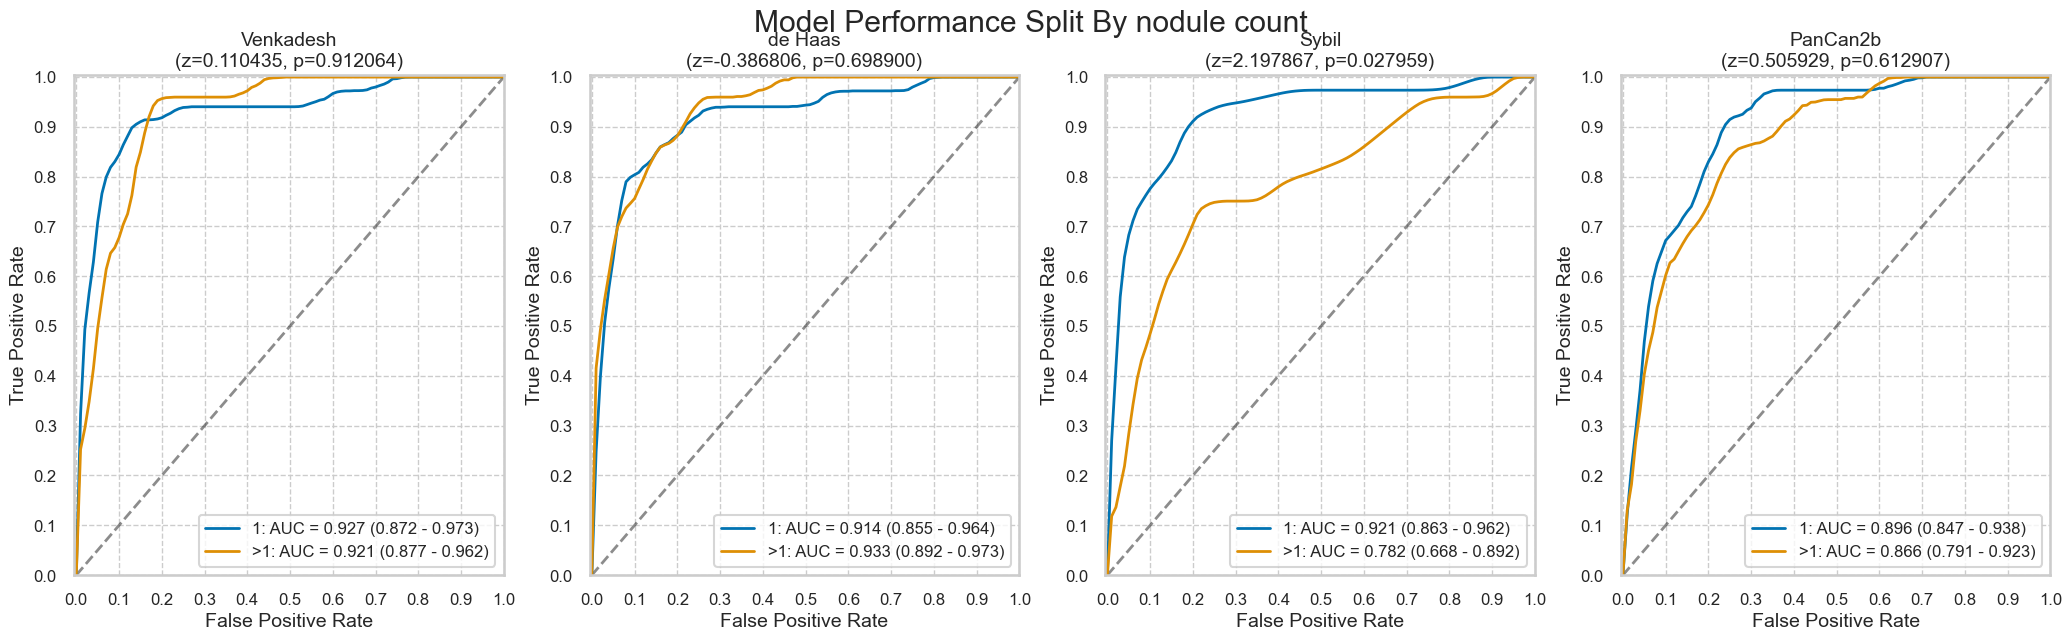

,Venkadesh,de Haas,Sybil,PanCan2b
z,0.110435,-0.386806,2.197867,0.505929
p,0.912064,0.698900,0.027959,0.612907


In [15]:
for q in SPLIT_QUERIES:
    rocs_splits(df_results, q)